### SVM代码实现

In [1]:
from numpy import *
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

In [23]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 

In [2]:
def loadDataSet(fileName):
    dataMat = []; labelMat = []
    fr = open(fileName)
    for line in fr.readlines():
        lineArr = line.strip().split('\t')
        dataMat.append([float(lineArr[0]), float(lineArr[1])])
        labelMat.append(float(lineArr[2]))
    return dataMat,labelMat

In [3]:
dataMat,labelMat=loadDataSet("3_data.txt")

### 画散点图

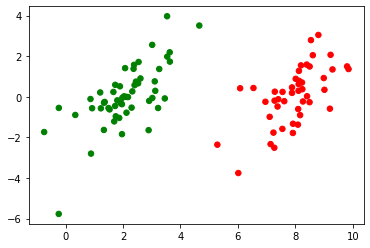

In [4]:
fig = plt.figure()
ax = fig.add_subplot(111)
cm_dark = mpl.colors.ListedColormap(['g', 'r'])
ax.scatter(array(dataMat)[:,0],array(dataMat)[:,1],c=array(labelMat).squeeze(),cmap=cm_dark,s=30)

### alpha的选取，随机选择一个不等于i值的j

In [5]:
def selectJrand(i,m):
    j=i
    while (j==i):
        j = int(random.uniform(0,m))
    return j

### 进行剪辑

<img src="images/01.png" align="left" width="300" />

In [6]:
def clipAlpha(aj,H,L):
    if aj > H:
        aj = H
    if L > aj:
        aj = L
    return aj

### SMO算法的核心实现
<img src="images/02.png" align="left" width="250" />
<img src="images/03.png" align="left" width="250" />
<img src="images/04.png" align="left" width="250" />

In [7]:
def smoSimple(dataMatIn, classLabels, C, toler, maxIter):
    dataMatrix = mat(dataMatIn); labelMat = mat(classLabels).transpose()
    #初始化b为0
    b = 0; 
    #获取数据维度
    m,n = shape(dataMatrix)
    #初始化所有alpha为0
    alphas = mat(zeros((m,1)))
    iter = 0
    #迭代求解
    while (iter < maxIter):
        alphaPairsChanged = 0
        for i in range(m):
            #计算g(xi)
            gXi = float(multiply(alphas,labelMat).T*(dataMatrix*dataMatrix[i,:].T)) + b
            #计算Ei
            Ei = gXi - float(labelMat[i])
            if ((labelMat[i]*Ei < -toler) and (alphas[i] < C)) or ((labelMat[i]*Ei > toler) and (alphas[i] > 0)):
                #随机选择一个待优化的alpha（先随机出alpha下标）
                j = selectJrand(i,m)
                #计算g(xj)
                gXj = float(multiply(alphas,labelMat).T*(dataMatrix*dataMatrix[j,:].T)) + b
                #计算Ej
                Ej = gXj - float(labelMat[j])
                #把原来的alpha值复制，作为old值
                alphaIold = alphas[i].copy(); alphaJold = alphas[j].copy();
                #计算上下界
                if (labelMat[i] != labelMat[j]):
                    L = max(0, alphas[j] - alphas[i])
                    H = min(C, C + alphas[j] - alphas[i])
                else:
                    L = max(0, alphas[j] + alphas[i] - C)
                    H = min(C, alphas[j] + alphas[i])
                if L==H: print("L==H"); continue
                #计算eta
                eta = 2.0 * dataMatrix[i,:]*dataMatrix[j,:].T - dataMatrix[i,:]*dataMatrix[i,:].T - dataMatrix[j,:]*dataMatrix[j,:].T
                if eta >= 0: print("eta>=0"); continue
                #计算alpha[j]，为了和公式对应把j看出2
                alphas[j] -= labelMat[j]*(Ei - Ej)/eta
                #剪辑alpha[j]，为了和公式对应把j看出2
                alphas[j] = clipAlpha(alphas[j],H,L)
                if (abs(alphas[j] - alphaJold) < 0.00001): print("j not moving enough"); continue
                #计算alpha[i] ，为了和公式对应把j看出1
                alphas[i] += labelMat[j]*labelMat[i]*(alphaJold - alphas[j])
                #计算b1
                b1 = b - Ei- labelMat[i]*(alphas[i]-alphaIold)*dataMatrix[i,:]*dataMatrix[i,:].T - labelMat[j]*(alphas[j]-alphaJold)*dataMatrix[i,:]*dataMatrix[j,:].T
                #计算b2
                b2 = b - Ej- labelMat[i]*(alphas[i]-alphaIold)*dataMatrix[i,:]*dataMatrix[j,:].T - labelMat[j]*(alphas[j]-alphaJold)*dataMatrix[j,:]*dataMatrix[j,:].T
                #求解b
                if (0 < alphas[i]) and (C > alphas[i]): b = b1
                elif (0 < alphas[j]) and (C > alphas[j]): b = b2
                else: b = (b1 + b2)/2.0
                alphaPairsChanged += 1
                print("iter: %d i:%d, pairs changed %d" % (iter,i,alphaPairsChanged))
        if (alphaPairsChanged == 0): iter += 1
        else: iter = 0
        print("iteration number: %d" % iter)
    return b,alphas

### 计算w
<img src="images/05.png" align="left" width="250" />

In [8]:
def calcWs(alphas,dataArr,classLabels):
    X = mat(dataArr); labelMat = mat(classLabels).transpose()
    m,n = shape(X)
    #初始化w都为1
    w = zeros((n,1))
    #循环计算
    for i in range(m):
        w += multiply(alphas[i]*labelMat[i],X[i,:].T)
    return w

### 调用上述方法，求解w，b，alpha

In [9]:
b,alphas = smoSimple(dataMat,labelMat,0.6,0.001,40)
w = calcWs(alphas,dataMat,labelMat)
# print('b=',b)
# print('alphas=',alphas)
# print('w=',w)

iter: 0 i:0, pairs changed 1
L==H
iter: 0 i:4, pairs changed 2
j not moving enough
iter: 0 i:6, pairs changed 3
j not moving enough
L==H
L==H
L==H
j not moving enough
iter: 0 i:29, pairs changed 4
L==H
j not moving enough
iter: 0 i:55, pairs changed 5
L==H
j not moving enough
iteration number: 0
j not moving enough
iter: 0 i:4, pairs changed 1
j not moving enough
j not moving enough
j not moving enough
iter: 0 i:10, pairs changed 2
L==H
iter: 0 i:27, pairs changed 3
j not moving enough
j not moving enough
j not moving enough
iter: 0 i:52, pairs changed 4
iter: 0 i:54, pairs changed 5
iter: 0 i:55, pairs changed 6
j not moving enough
j not moving enough
iteration number: 0
j not moving enough
j not moving enough
iter: 0 i:6, pairs changed 1
j not moving enough
j not moving enough
j not moving enough
L==H
j not moving enough
iter: 0 i:27, pairs changed 2
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iter: 0 i:69, pairs changed 3
iter:

j not moving enough
j not moving enough
j not moving enough
iteration number: 11
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 12
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 13
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 14
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number

j not moving enough
j not moving enough
iteration number: 2
j not moving enough
iter: 2 i:17, pairs changed 1
j not moving enough
j not moving enough
j not moving enough
iteration number: 0
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 1
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 2
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 3
j not moving enough
j not moving enough
j not moving enough
iter: 3 i:54, pairs changed 1
j not moving enough
iteration number: 0
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 1
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 2
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 3
j not moving enough


iteration number: 22
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 23
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 24
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 25
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 26
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 27
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 28
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 29
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 30
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 31
j not moving enough
j not moving enough
j not moving enough
j not movi

### 画决策平面

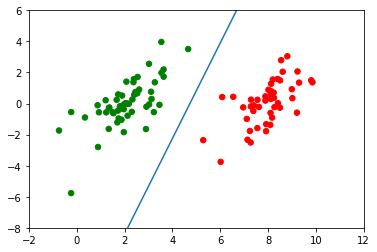

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111)
cm_dark = mpl.colors.ListedColormap(['g', 'r'])
ax.scatter(array(dataMat)[:,0],array(dataMat)[:,1],c=array(labelMat).squeeze(),cmap=cm_dark,s=30)

x = arange(-2.0, 12.0, 0.1)
y = (-w[0]*x - b)/w[1]
ax.plot(x,y.reshape(-1,1))
ax.axis([-2,12,-8,6])
plt.show()

### 画支持向量

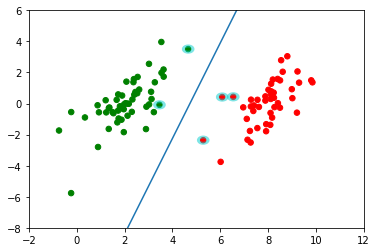

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111)
cm_dark = mpl.colors.ListedColormap(['g', 'r'])
ax.scatter(array(dataMat)[:,0],array(dataMat)[:,1],c=array(labelMat).squeeze(),cmap=cm_dark,s=30)

x = arange(-2.0, 12.0, 0.1)
y = (-w[0]*x - b)/w[1]
ax.plot(x,y.reshape(-1,1))
ax.axis([-2,12,-8,6])


alphas_non_zeros_index = where(alphas>0)
for i in alphas_non_zeros_index[0]:
    circle = Circle((dataMat[i][0], dataMat[i][1]), 0.2, facecolor='none', edgecolor=(0,0.8,0.8), linewidth=3, alpha=0.5)
    ax.add_patch(circle)
plt.show()

## SVM训练

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import svm, datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [14]:
x = dataMat
y = labelMat

In [15]:
# 数据预处理: 数据归一化
scaler = StandardScaler()
scaler.fit(x)
X = scaler.transform(x)

In [28]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,shuffle=True)

In [30]:
X_train
y_train
X_test
y_test

array([[-0.04298308,  2.3654834 ],
       [-0.99197426, -0.35135798],
       [ 1.21586705,  1.87254189],
       [ 1.36033484,  0.59275105],
       [-0.89154258, -0.02547605],
       [ 0.75057848, -0.71750748],
       [ 0.91511117, -0.19002631],
       [-0.9374504 ,  0.3128214 ],
       [ 1.04403953,  0.5668012 ],
       [ 1.20133925,  0.9832219 ],
       [ 1.08034365,  0.83367877],
       [-1.10979799, -0.21480657],
       [-0.4945926 ,  0.89783551],
       [ 0.80289741, -1.76083015],
       [ 0.56765442,  0.25662885],
       [-0.91547266, -0.29105368],
       [-0.75774841,  0.47051875],
       [ 1.00234339,  0.09106745],
       [-1.00208313, -0.87225719],
       [ 1.63965248,  0.89592712],
       [-0.78417066,  0.90318408],
       [-0.99062877,  0.36359472],
       [-0.79811072,  0.14141821],
       [-0.77845254,  1.03862077],
       [-0.37463972,  1.14659778],
       [-0.5721965 , -0.07988162],
       [-0.84684295, -0.05047719],
       [ 1.10303348,  1.01941408],
       [-0.53916205,

[-1.0,
 -1.0,
 1.0,
 1.0,
 -1.0,
 1.0,
 1.0,
 -1.0,
 1.0,
 1.0,
 1.0,
 -1.0,
 -1.0,
 1.0,
 1.0,
 -1.0,
 -1.0,
 1.0,
 -1.0,
 1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 1.0,
 -1.0,
 1.0,
 -1.0,
 1.0,
 1.0,
 -1.0,
 1.0,
 -1.0,
 1.0,
 1.0,
 -1.0,
 -1.0,
 -1.0,
 1.0,
 -1.0,
 -1.0,
 1.0,
 1.0,
 1.0,
 -1.0,
 1.0,
 -1.0,
 -1.0,
 1.0,
 -1.0,
 1.0,
 1.0,
 1.0,
 -1.0,
 1.0,
 1.0,
 -1.0,
 -1.0,
 1.0,
 -1.0,
 -1.0,
 -1.0,
 1.0,
 -1.0,
 -1.0,
 1.0,
 1.0]

array([[ 0.80585167, -0.17055415],
       [-0.40427756,  1.31593891],
       [ 1.23692189,  1.36348403],
       [-0.37642303,  1.46218044],
       [ 0.7026163 , -0.20881867],
       [-0.70639416,  0.57891145],
       [-0.73218106,  0.41405593],
       [-0.50772277, -0.41944058],
       [-1.79204019, -1.23143991],
       [ 1.0122489 , -1.26274244],
       [-0.80627178, -0.40681584],
       [-0.57382923,  1.71313234],
       [-0.86653448, -0.04357557],
       [ 1.29968647,  2.04781056],
       [ 0.84743091, -0.12417451],
       [ 0.16059686, -1.65824356],
       [ 1.07707916,  0.3871903 ],
       [-0.94572351, -0.75421689],
       [-0.98482095, -0.7003553 ],
       [ 1.09378404, -0.66052263],
       [ 1.12534638, -0.19895706],
       [ 1.0756417 ,  0.16242696],
       [ 0.79305828, -1.25077693],
       [ 0.39671191, -2.61547466],
       [-0.61435701, -1.16789436],
       [-0.60840542, -0.17932575],
       [-0.40619785,  2.67936209],
       [-0.72751117,  1.13536695],
       [-0.86386194,

[1.0,
 -1.0,
 1.0,
 -1.0,
 1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 1.0,
 -1.0,
 -1.0,
 -1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 -1.0,
 -1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0]

In [31]:
#引入模型 线性SVM：
model_linear = svm.SVC(C=1e9, kernel='linear')
# 模型训练
model_linear.fit(X_train, y_train)

SVC(C=1000000000.0, kernel='linear')

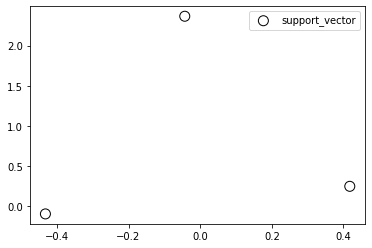

In [42]:
# 绘制支持向量
plt.scatter(model_linear.support_vectors_[:,0],model_linear.support_vectors_[:,1],s=100, c="none", edgecolor='k', marker="o",label="support_vector")
plt.legend()
plt.show()


In [32]:
model_linear.score(X_test,y_test)

1.0

In [33]:
#引入模型 高斯核SVM：
model_RBF = svm.SVC(C=1e9, kernel='rbf')
# 模型训练
model_RBF.fit(X_train, y_train)

SVC(C=1000000000.0)

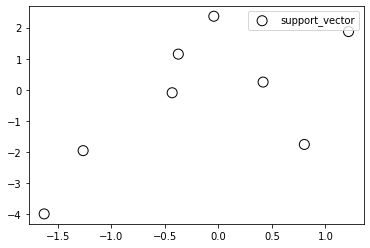

In [41]:
# 绘制支持向量
plt.scatter(model_RBF.support_vectors_[:,0],model_RBF.support_vectors_[:,1],s=100, c="none", edgecolor='k', marker="o",label="support_vector")
plt.legend()
plt.show()


In [34]:
model_RBF.score(X_test,y_test)

1.0

## SVR

In [66]:
X = [i[0] for i in dataMat]
y = labelMat

In [68]:
X = np.array(X).reshape(-1,1)
y = np.array(y).reshape(-1,1)

In [69]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,shuffle=True)

In [70]:
X_train
y_train

array([[ 7.616862],
       [ 3.125951],
       [ 7.139979],
       [-0.236713],
       [ 2.609525],
       [ 7.270337],
       [ 3.542485],
       [ 1.749721],
       [ 3.628502],
       [ 2.037772],
       [ 1.497407],
       [ 7.886242],
       [ 8.398012],
       [ 3.634009],
       [ 2.529893],
       [ 7.40786 ],
       [ 2.114999],
       [ 0.92631 ],
       [ 6.960661],
       [ 7.27946 ],
       [ 3.107511],
       [ 8.102154],
       [ 1.966279],
       [ 5.286862],
       [ 8.54562 ],
       [ 3.263585],
       [ 2.301095],
       [ 8.197181],
       [ 7.382988],
       [ 2.123252],
       [ 1.208047],
       [ 3.018896],
       [ 6.543888],
       [ 9.803425],
       [ 8.804461],
       [ 2.893743],
       [ 7.239953],
       [ 8.500757],
       [ 8.168618],
       [ 8.117032],
       [ 0.887835],
       [ 1.727631],
       [ 3.223038],
       [ 8.015003],
       [ 1.928486],
       [ 3.023938],
       [-0.232542],
       [ 7.55151 ],
       [ 8.410143],
       [ 3.536555],


array([[ 1.],
       [-1.],
       [ 1.],
       [-1.],
       [-1.],
       [ 1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [ 1.],
       [ 1.],
       [-1.],
       [-1.],
       [ 1.],
       [-1.],
       [-1.],
       [ 1.],
       [ 1.],
       [-1.],
       [ 1.],
       [-1.],
       [ 1.],
       [ 1.],
       [-1.],
       [-1.],
       [ 1.],
       [ 1.],
       [-1.],
       [-1.],
       [-1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [-1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [-1.],
       [-1.],
       [-1.],
       [ 1.],
       [-1.],
       [-1.],
       [-1.],
       [ 1.],
       [ 1.],
       [-1.],
       [-1.],
       [-1.],
       [ 1.],
       [-1.],
       [-1.],
       [-1.],
       [ 1.],
       [-1.],
       [-1.],
       [ 1.],
       [-1.],
       [-1.],
       [-1.],
       [ 1.],
       [-1.],
       [-1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.]])

In [71]:
svr = svm.SVR(kernel='rbf', gamma=10, C=1)

In [72]:
svr.fit(X_train.reshape(-1,1),y_train.reshape(-1,1))

D:\Anaconda\envs\torch\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR(C=1, gamma=10)

In [73]:
svr.score(X_test,y_test)

0.961322159243186